# Instrumental Variables

# 1. Data simulation: a predictor of the outcome

In [1]:
from numpy.random import seed, normal, binomial, uniform
from numpy import cov
import statsmodels.formula.api as smf
from pandas import DataFrame
from seaborn import kdeplot
import doubleml as dml
from sklearn.linear_model import LinearRegression, LogisticRegression
from linearmodels.iv.model import IV2SLS

n = 1000
instrument_impact = 0.7
treatment_effect = -2

confounder = binomial(1, 0.3, n)
instrument = binomial(1, 0.5, n)
treatment = (
    uniform(0, 1, n) <= instrument_impact * instrument + 0.4 * confounder
).astype(int)
outcome = 30 + treatment_effect * treatment + 10 * confounder + normal(0, 2, n)

df = DataFrame({"instrument": instrument, "treatment": treatment, "outcome": outcome})

# 2. Naive estimation

In [2]:
smf.ols(formula="outcome ~ treatment", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     12.20
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           0.000499
Time:                        18:47:12   Log-Likelihood:                -2974.1
No. Observations:                1000   AIC:                             5952.
Df Residuals:                     998   BIC:                             5962.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.6567      0.197    160.824      0.000      31.270      32.043
treatment      1.0608      0.304      3.493      0.000       0.465       1.657
==============================================================================
Omnibus:                       64.720   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.477
Skew:                           0.566   Prob(JB):                     1.64e-14
Kurtosis:                       2.509   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
outcome_1 = df[df.treatment==1].outcome.mean()
outcome_0 = df[df.treatment==0].outcome.mean()
print(outcome_1 - outcome_0)

1.0608181513166528


# 3. IV estimation

In [4]:
cov(instrument, outcome)[0][1]/cov(instrument, treatment)[0][1]

-2.1031996936531288

# 4. Two-Stage Least Squares Estimation

In [5]:
model = smf.ols(formula='treatment ~ instrument', data=df).fit()
df['treatment_prediction'] = model.predict(df)

smf.ols(formula='outcome ~ treatment_prediction', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     20.23
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           7.68e-06
Time:                        18:47:13   Log-Likelihood:                -2970.1
No. Observations:                1000   AIC:                             5944.
Df Residuals:                     998   BIC:                             5954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               32.9855      0.247    133.695      0.000      32.501      33.470
treatment_prediction    -2.1032      0.468     -4.497      0.000      -3.021      -1.186
==============================================================================
Omnibus:                      101.245   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.574
Skew:                           0.663   Prob(JB):                     2.15e-20
Kurtosis:                       2.354   Cond. No.                         3.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
IV2SLS.from_formula('outcome ~ 1  + [treatment ~ instrument]',df).fit()

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                outcome   R-squared:                     -0.0953
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0964
No. Observations:                1000   F-statistic:                    18.131
Date:                Tue, Dec 19 2023   P-value (F-stat)                0.0000
Time:                        18:47:13   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      32.986     0.2603     126.72     0.0000      32.475      33.496
treatment     -2.1032     0.4939    -4.2580     0.0000     -3.0713     -1.1351
==============================================================================

Endogenous: treatment
Instruments: instrument
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x1334d3710

# 5. Weak instruments

In [7]:
def generate_data(instrument_impact, n):
    confounder = binomial(1, 0.3, n)
    instrument = binomial(1, 0.5, n)
    treatment = (uniform(0, 1, n) <= instrument_impact*instrument + 0.4*confounder).astype(int)
    outcome = 30 + instrument_impact*treatment + 10 * confounder + normal(0, 2, n)

    return(DataFrame({
        'instrument': instrument,
        'treatment': treatment,
        'outcome': outcome
    }))

def estimate_impact(df):
    return(cov(df.instrument, df.outcome)[0][1]/cov(df.instrument, df.treatment)[0][1])

In [8]:
sim_n = 1000

instrument_impact_1 = 0.3
estimates_1 = []
for i in range(sim_n):
    df = generate_data(instrument_impact_1, n)
    estimates_1.append(estimate_impact(df))

In [9]:
instrument_impact_2 = 0.1
estimates_2 = []
for i in range(sim_n):
    df = generate_data(instrument_impact_2, n)
    estimates_2.append(estimate_impact(df))

<Axes: xlabel='estimate', ylabel='Density'>

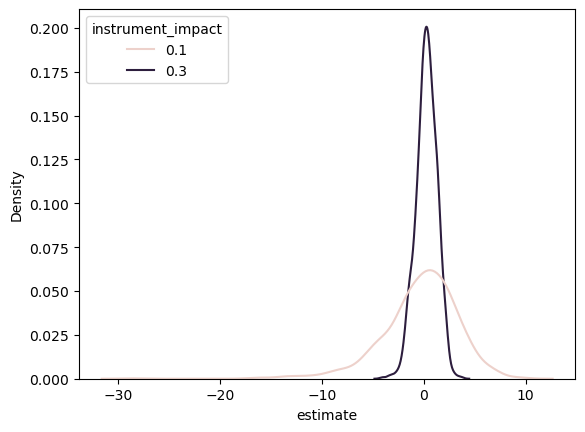

In [10]:
df_plot = DataFrame({
    'estimate': estimates_1 + estimates_2,
    'instrument_impact': [instrument_impact_1]*n + [instrument_impact_2]*n
})
kdeplot(data = df_plot, x='estimate', hue='instrument_impact')

# 6. DoubleML

In [11]:
n = 10000
df = generate_data(0.5, 1000)

print(estimate_impact(df))
df['x'] = 1

ml_g = LinearRegression()
ml_m = LogisticRegression(penalty=None)
ml_r = LogisticRegression(penalty=None)

obj_dml_data = dml.DoubleMLData(df, y_col='outcome', d_cols='treatment', z_cols='instrument')
dml_iivm_obj = dml.DoubleMLIIVM(obj_dml_data, ml_g, ml_m, ml_r)
dml_iivm_obj.fit().summary

0.8260480975773862


,coef,std err,t,P>|t|,2.5 %,97.5 %
treatment,0.797153,0.646525,1.232981,0.217583,-0.470013,2.064318


In [12]:
cov(df.instrument, df.outcome)[0][1] / cov(df.instrument, df.treatment)[0][1]

0.8260480975773862